In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
import os, os.path 
import numpy as np
import pickle
from glob import glob
import pandas as pd
import matplotlib.pyplot as plt

# Load one training sample

In [2]:
train_path = "./train/train"
# The glob module finds all the pathnames matching a specified pattern
train_pkl_lst = glob(os.path.join(train_path, '*'))
with open(train_pkl_lst[0], 'rb') as f:
    training_sample = pickle.load(f)

In [3]:
# There are at most 60 agents/vehicles in a scene
# 'agent_id' is the track id for the agent to be predicted in this scene
training_sample.keys()

dict_keys(['city', 'lane', 'lane_norm', 'scene_idx', 'agent_id', 'car_mask', 'p_in', 'v_in', 'p_out', 'v_out', 'track_id'])

In [4]:
training_sample['agent_id']

'00000000-0000-0000-0000-000000044289'

In [5]:
training_sample['p_in'].shape

(60, 19, 2)

In [6]:
training_sample['lane'].shape

(216, 2)

In [56]:
scene = training_sample
# the index of agent to be predicted 
pred_id = np.where(scene["track_id"] == scene['agent_id'])[0][0]
# print(pred_id, "pred_id")
# print(scene['car_mask'], "scene[car_mask]", scene['car_mask'].shape)
# input: p_in & v_in; output: p_out
p_in_raw = scene['p_in'][pred_id]
p_out_raw = scene['p_out'][pred_id]
v_in_raw = scene['v_in'][pred_id]
v_out_raw = scene['v_out'][pred_id]
lane_scene = scene['lane']
# print(p_in_raw.shape,p_out_raw.shape,v_in_raw.shape,v_out_raw.shape,lane_scene.shape)

# Normalization
min_vecs = np.min(lane_scene, axis = 0)
max_vecs = np.max(lane_scene, axis = 0)
# print(min_vecs,max_vecs)
lane_scene_normalized = (lane_scene - min_vecs)/(max_vecs - min_vecs)
lane_norm_scene = scene['lane_norm']
lane_norm_scene_normalized = lane_norm_scene/np.linalg.norm(lane_norm_scene,axis=1,keepdims=True)

# Normalize by vectors
p_in_normalized = (p_in_raw - min_vecs)/(max_vecs - min_vecs)
p_out_normalized = (p_out_raw - min_vecs)/(max_vecs - min_vecs)

v_in_normalized = v_in_raw / np.linalg.norm(v_in_raw, axis=1, keepdims=True)
print(v_in_normalized.shape)
# v_out_normalized = v_out_raw / np.linalg.norm(v_out_raw, axis=1, keepdims=True)
inp = np.concatenate((p_in_normalized,v_in_normalized),axis=1)
print(inp.shape)

(19, 2)
(19, 4)


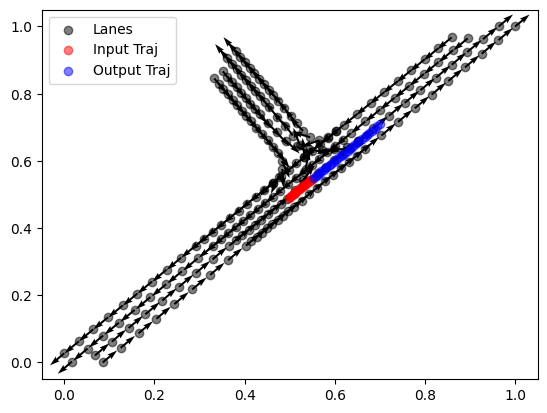

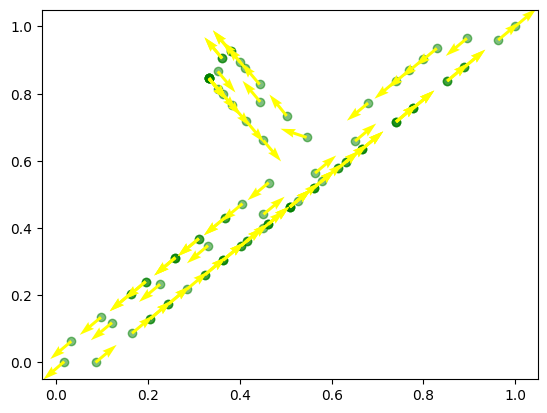

In [59]:
plt.scatter(lane_scene_normalized[:,0], lane_scene_normalized[:,1], alpha=0.5, label = "Lanes", color = "black")
plt.quiver(lane_scene_normalized[:,0], lane_scene_normalized[:,1], lane_norm_scene_normalized[:,0], lane_norm_scene_normalized[:,1], color='black')
plt.scatter(p_in_normalized[:,0], p_in_normalized[:,1], alpha=0.5, label = "Input Traj", color = "red")
plt.scatter(p_out_normalized[:,0], p_out_normalized[:,1], alpha=0.5, label = "Output Traj", color = "blue")
       
plt.legend()
# plt.xticks([])
# plt.yticks([])
plt.show()
grid_x, grid_y = np.meshgrid(np.linspace(0, 1, 10), np.linspace(0, 1, 10), indexing='ij')

from scipy.interpolate import griddata
grid_ps = griddata(lane_scene_normalized, lane_scene_normalized, (grid_x, grid_y), method='nearest')
grid_vs = griddata(lane_scene_normalized, lane_norm_scene_normalized, (grid_x, grid_y), method='nearest')
print()
plt.scatter(grid_ps.reshape(-1,2)[:,0], grid_ps.reshape(-1,2)[:,1], alpha=0.5, label = "Input Traj", color = "green")
plt.quiver(grid_ps.reshape(-1,2)[:,0], grid_ps.reshape(-1,2)[:,1], grid_vs.reshape(-1,2)[:,0], grid_vs.reshape(-1,2)[:,1], color='yellow')

# Examining the submission format

In [14]:
test_path = "./val_in/val_in/"
test_pkl_list = glob(os.path.join(test_path, '*'))
test_pkl_list.sort()
with open(test_pkl_list[0], 'rb') as f:
    test_sample = pickle.load(f)

In [15]:
test_sample.keys()

dict_keys(['city', 'lane', 'lane_norm', 'scene_idx', 'agent_id', 'car_mask', 'p_in', 'v_in', 'track_id'])

In [18]:
test_sample['p_in'].shape

(60, 19, 2)

In [19]:
# Submission Files: a sample submission file in the correct format
# 30-step ahead predictions of positions. 
sample_sub = pd.read_csv('sample_submission.csv')
sample_sub.head()

,ID,v1,v2,v3,v4,v5,v6,v7,v8,v9,...,v51,v52,v53,v54,v55,v56,v57,v58,v59,v60
0,10002,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,10015,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,10019,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,10028,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1003,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [20]:
predictions = np.random.randn(3200, 60)

In [21]:
sub_df = pd.DataFrame(np.c_[sample_sub["ID"], predictions], columns=[np.r_[["ID"], ["v" + str(i) for i in range(1,61)]]])
sub_df.to_csv('test_submission.csv', index=None)